# DreamBooth Hackathon 🏆

Welcome to the DreamBooth Hackathon! In this competition, you'll **personalise a Stable Diffusion model by fine-tuning it on a handful of your own images.** To do so, we'll use a technique called [_DreamBooth_](https://arxiv.org/abs/2208.12242), which allows one to implant a subject (e.g. your pet or favourite dish) into the output domain of the model such that it can be synthesized with a _unique identifier_ in the prompt.

Let's dive in!

## Info
* DreamBooth [blog post](https://dreambooth.github.io/) to get a sense of what's possible with this technique
* Hugging Face [blog post](https://huggingface.co/blog/dreambooth) on best practices for fine-tuning Stable Diffusion with DreamBooth

🚨 **Note:** the code in **this notebook requires at least 14GB of GPU vRAM** and is a simplified version of the [official training script](https://github.com/huggingface/diffusers/tree/main/examples/dreambooth) provided in 🤗 Diffusers. It produces decent models for most applications, but we recommend experimenting with the advanced features like class preservation loss & fine-tuning the text encoder if you have at least 24GB vRAM available. Check out the 🤗 Diffusers [docs](https://huggingface.co/docs/diffusers/training/dreambooth) for more details.

## What is DreamBooth?

DreamBooth is a technique to teach new concepts to Stable Diffusion using a specialized form of fine-tuning. If you're on Twitter or Reddit, you may have seen people using this technique to create (often hilarious) avatars of themselves. For example, here's what [Andrej Karpathy](https://karpathy.ai/) would look like as a cowboy (you may need to run the cell to see the output):

The way DreamBooth works is as follows:

* Collect around 10-20 input images of a subject (e.g. your dog) and define a unique identifier [V] the refers to the subject. This identifier is usually some made up word like `flffydog` which is implanted in different text prompts at inference time to place the subject in different contexts.
* Fine-tune the diffusion model by providing the images together with a text prompt like "A photo of a [V] dog" that contains the unique identifier and class name (i.e. "dog" in this example)
* (Optionally) Apply a special _class-specific prior preservation loss_, which leverages the semantic prior that the model has on the class and encourages it to generate diverse instances belong to the subject's class by injecting the class name in the text prompt. In practice, this step is only really needed for human faces and can be skipped for the themes we'll be exploring in this hackathon.

An overview of the DreamBooth technique is shown in the image below:

![](https://dreambooth.github.io/DreamBooth_files/high_level.png)

### What can DreamBooth do?

Besides putting your subject in interesting locations, DreamBooth can be used for _**text-guided view synthesis**_, where the subject is viewed from different viewpoints as shown in the example below:

![](https://dreambooth.github.io/DreamBooth_files/novel_views.png)

DreamBooth can also be used to modify properties of the subject, such as colour or mixing up animal species!

![](https://dreambooth.github.io/DreamBooth_files/property_modification.png)

### Visit Stable Diffusion Prompt Book :
https://openart.ai/promptbook

## Step 1: Setup

If you're running this notebook on Google Colab or Kaggle, run the cell below to install the required libraries:

In [1]:
%pip install -qqU diffusers transformers bitsandbytes accelerate ftfy datasets wandb

Note: you may need to restart the kernel to use updated packages.


To be able to push your model to the Hub and make it appear on the [DreamBooth Leaderboard](https://huggingface.co/spaces/dreambooth-hackathon/leaderboard), there are a few more steps to follow. First you have to create an [access token](https://huggingface.co/docs/hub/security-tokens) with _**write access**_ from your Hugging Face account and then execute the following cell and input your token:

In [2]:
from huggingface_hub import notebook_login

notebook_login()

The final step is to install Git LFS:

In [3]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [4]:
import torch
import wandb
import os
import math
import itertools
import logging
import torch.nn.functional as F

from pathlib import Path
from accelerate import Accelerator
from accelerate.utils import set_seed
from accelerate.logging import get_logger
from accelerate import notebook_launcher

from diffusers import DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from diffusers.utils.import_utils import is_xformers_available
from diffusers.optimization import get_scheduler

from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm

from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer
from datasets import load_dataset
from torchvision import transforms

from PIL import Image
from psutil import virtual_memory
from argparse import Namespace
import ipywidgets as widgets

## Step 2: Pick a theme

This competition is composed of 5 _themes_, where each theme will collect models belong to the following categories:

* **Animal 🐨:** Use this theme to generate images of your pet or favourite animal hanging out in the Acropolis, swimming, or flying in space.
* **Science 🔬:** Use this theme to generate cool synthetic images of galaxies, proteins, or any domain of the natural and medical sciences.
* **Food 🍔:** Use this theme to tune Stable Diffusion on your favourite dish or cuisine.
* **Landscape 🏔:** Use this theme to generate beautiful landscapes of your faourite mountain, lake, or garden.
* **Wildcard 🔥:** Use this theme to go wild and create Stable Diffusion models for any category of your choosing!

We'll be **giving out prizes to the top 3 most liked models per theme**, and you're encouraged to submit as many models as you want! Run the cell below to create a dropdown widget where you can select the theme you wish to submit to:

In [5]:
theme = "landscape"
drop_down = widgets.Dropdown(
    options=["animal", "science", "food", "landscape", "wildcard"],
    description="Pick a theme",
    disabled=False,
)


def dropdown_handler(change):
    global theme
    theme = change.new


drop_down.observe(dropdown_handler, names="value")
display(drop_down)

Dropdown(description='Pick a theme', options=('animal', 'science', 'food', 'landscape', 'wildcard'), value='an…

In [6]:
print(f"You've selected the {theme} theme!")

You've selected the landscape theme!


## Step 3: Create an image dataset and upload it to the Hub

Once you've picked a theme, the next step is to **create a dataset of images for that theme** and upload it to the Hugging Face Hub:

* You'll need around **10-20 images of the subject** that you wish to implant in the model. These can be photos you've taken or downloaded from platforms like [Unsplash](https://unsplash.com/). Alternatively, you can take a look at any of the [image datasets](https://huggingface.co/datasets?task_categories=task_categories:image-classification&sort=downloads) on the Hugging Face Hub for inspiration.
* For best results, we recommend using images of your subject from **different angles and perspectives** 

Alternatively, you can load your dataset locally using the `imagefolder` feature of 🤗 Datasets and then push it to the Hub:

```python
from datasets import load_dataset

dataset = load_dataset("imagefolder", data_dir="your_folder_of_images")
# Remove the dummy label column
dataset = dataset.remove_columns("label")
# Push to Hub
dataset.push_to_hub("dreambooth-hackathon-images")
```

Once you've created your dataset, you can download it by using the `load_dataset()` function as follows:

In [7]:
dataset_id = "CCMat/db-forest-ruins"  #CHANGE THIS TO YOUR {hub_username}/{dataset_id}
dataset = load_dataset(dataset_id, split="train")
dataset

Using custom data configuration CCMat--db-forest-ruins-5f2f81ead513b81f
Found cached dataset imagefolder (/root/.cache/huggingface/datasets/CCMat___imagefolder/CCMat--db-forest-ruins-5f2f81ead513b81f/0.0.0/37fbb85cc714a338bea574ac6c7d0b5be5aff46c1862c1989b20e0771199e93f)


Dataset({
    features: ['image'],
    num_rows: 17
})

Now that we have our dataset, let's define a helper function to view a few of the images:

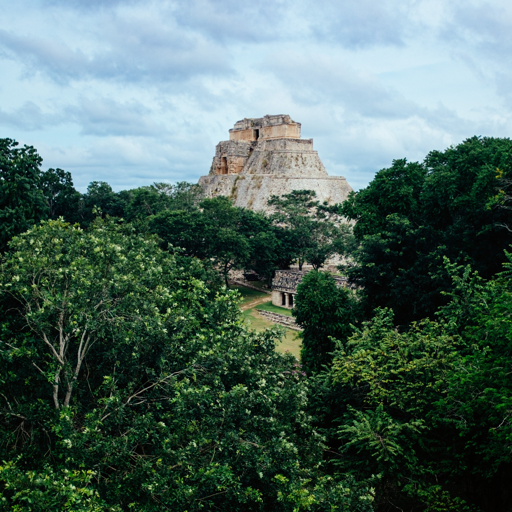

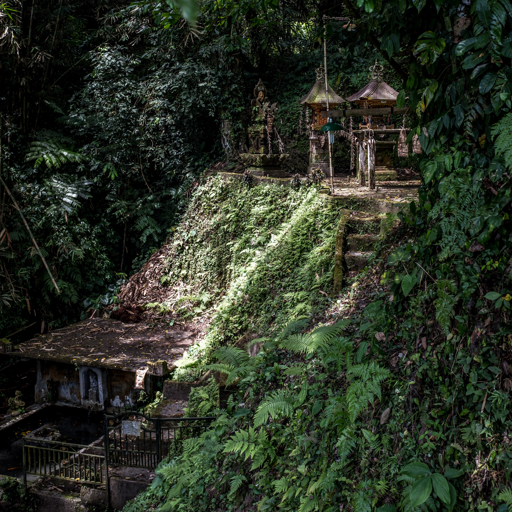

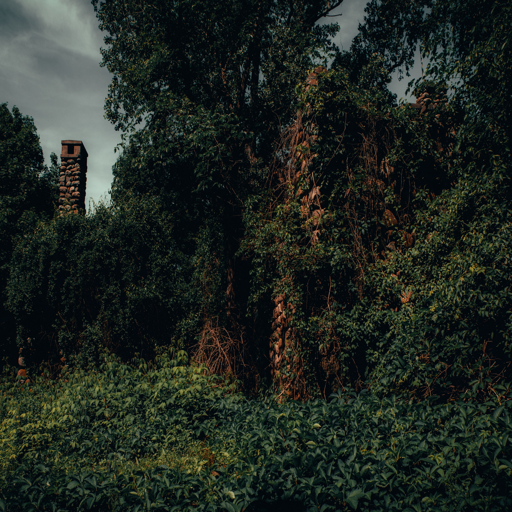

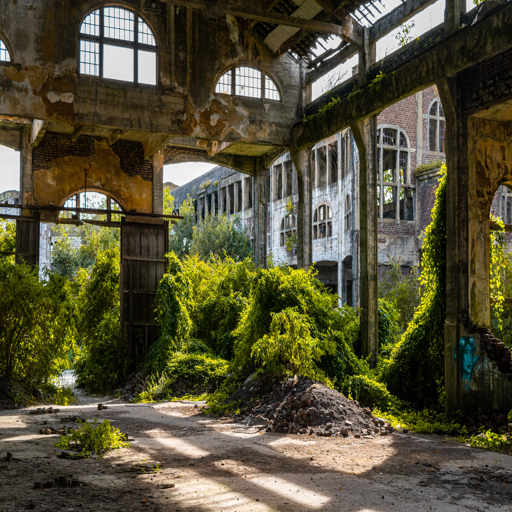

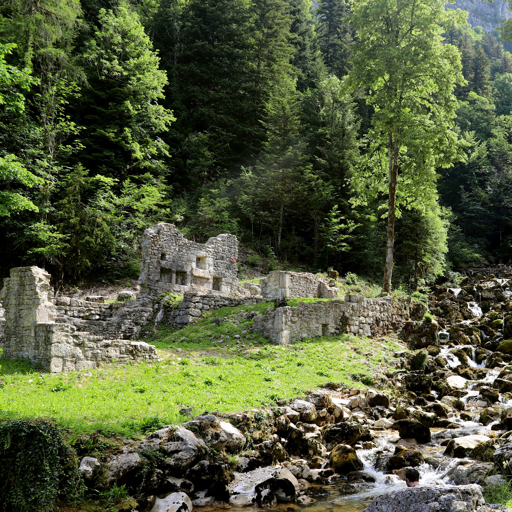

In [8]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size
    for i, img in enumerate(imgs):
        display(img.resize((512, 512)))
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid


num_samples = 5
img_grid = image_grid(dataset["image"][:num_samples], rows=1, cols=num_samples)

If this looks good, you can move onto the next step - creating a PyTorch dataset for training with DreamBooth.

## Step 3: Create a training dataset

To create a training set for our images we need a few components:

* An _instance prompt_ that is used to prime the model at the start of training. In most cases, using "a photo of [identifier] [class noun]" works quite well, e.g. "a photo of ccorgi dog" for our cute Corgi pictures. 
    * **Note:** it is recommended that you pick a unique / made up word like `ccorgi` to describe your subject. This will ensure a common word in the model's vocabulary isn't overwritten.
* A _tokenizer_ to convert the instance prompt into input IDs that can be fed to the text encoder of Stable Diffusion
* A set of _image transforms_, notably resizing the images to a common shape and normalizing the pixel values to a common mean and standard distribution.

With this in mind, let's start by defining the instance prompt:

In [9]:
name_of_your_concept = "fgreeneruins"
type_of_thing = "ruins" 
instance_prompt = f"a photo of {name_of_your_concept} {type_of_thing}"
print(f"Instance prompt: {instance_prompt}")

Instance prompt: a photo of fgreeneruins ruins


Next, we need to create a PyTorch `Dataset` object that implements the `__len__` and `__getitem__` dunder methods:

In [10]:
class DreamBoothDataset(Dataset):
    """
    A dataset to prepare the instance and class images with the prompts for fine-tuning the model.
    It pre-processes the images and the tokenizes prompts.
    """

    def __init__(
        self,
        dataset,
        instance_prompt,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.dataset = dataset
        self.instance_prompt = instance_prompt
        self._length = len(dataset)

        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(self.class_data_root.iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}
        image = self.dataset[index]["image"]
        example["instance_images"] = self.image_transforms(image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            truncation=True,
            #padding="max_length",
            padding="do_not_pad",
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                truncation=True,
                padding="max_length",
                max_length=self.tokenizer.model_max_length,
                return_tensors="pt",
            ).input_ids

        return example        

Great, let's now check this works by loading the CLIP tokenizer associated with the text encoder of the original Stable Diffusion model, and then creating the training dataset:

In [11]:
#'mdjrny-v4 style'
#elden ring style

# The Stable Diffusion checkpoint we'll fine-tune
model_id = "prompthero/openjourney"#

tokenizer = CLIPTokenizer.from_pretrained(
    model_id,
    subfolder="tokenizer",
)

train_dataset = DreamBoothDataset(dataset, instance_prompt, tokenizer)

In [12]:
print(len(train_dataset))

17


## Step 4: Define a data collator

Now that we have a training dataset, the next thing we need is to define a _data collator_. A data collator is a function that collects elements in a batch of data and applies some logic to form a single tensor we can provide to the model. If you'd to learn more, you can check out this video from the [Hugging Face Course](hf.co/course):

For DreamBooth, our data collator need to provide the model with the input IDs from the tokenizer and the pixel values from the images as a stacked tensor. The function below does the trick:

In [13]:
def collate_fn(examples, with_prior_preservation=False):
    input_ids = [example["instance_prompt_ids"] for example in examples]
    pixel_values = [example["instance_images"] for example in examples]

    # Concat class and instance examples for prior preservation.
    # We do this to avoid doing two forward passes.
    if with_prior_preservation:
        print("with prior preservation")
        input_ids += [example["class_prompt_ids"] for example in examples]
        pixel_values += [example["class_images"] for example in examples]

    pixel_values = torch.stack(pixel_values)
    pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

    input_ids = tokenizer.pad(
        {"input_ids": input_ids}, padding=True, return_tensors="pt"
    ).input_ids

    batch = {
        "input_ids": input_ids,
        "pixel_values": pixel_values,
    }
    return batch


## Step 5: Load the components of the Stable Diffusion pipeline

We nearly have all the pieces ready for training! As you saw in the Unit 3 notebook on Stable Diffusion, the pipeline is composed of several models:

* A text encoder that converts the prompts into text embeddings. Here we're using CLIP since it's the encoder used to train Stable Diffusion v1-4
* A VAE or variational autoencoder that converts the images to compressed representations (i.e. latents) and decompresses them at inference time
* A UNet that applies the denoising operation on the latent of the VAE

We can load all these components using the 🤗 Diffusers and 🤗 Transformers libraries as follows:

In [14]:
text_encoder = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(model_id, subfolder="vae")
unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
feature_extractor = CLIPFeatureExtractor.from_pretrained("openai/clip-vit-base-patch32")

## Step 6: Fine-tune the model

Now comes the fun part - training our model with DreamBooth! As shown in the [Hugging Face's blog post](https://huggingface.co/blog/dreambooth), the most essential hyperparameters to tweak are the learning rate and number of training steps.

In general, you'll get better results with a lower learning rate at the expense of needing to increase the number of training steps. The values below are a good starting point, but you may need to adjust them according to your dataset: 

- Dreambooth tends to overfit quickly. To get good-quality images, we must find a 'sweet spot' between the number of training steps and the learning rate. We recommend using a low learning rate and progressively increasing the number of steps until the results are satisfactory.
- Dreambooth needs more training steps for faces. In our experiments, 800-1200 steps worked well when using a batch size of 2 and LR of 1e-6.
Prior preservation is important to avoid overfitting when training on faces. For other subjects, it doesn't seem to make a huge difference.
- If you see that the generated images are noisy or the quality is degraded, it likely means overfitting. First, try the steps above to avoid it. If the generated images are still noisy, use the DDIM scheduler or run more inference steps (~100 worked well in our experiments).
- Training the text encoder in addition to the UNet has a big impact on quality. Our best results were obtained using a combination of text encoder fine-tuning, low LR, and a suitable number of steps. However, fine-tuning the text encoder requires more memory, so a GPU with at least 24 GB of RAM is ideal. Using techniques like 8-bit Adam, fp16 training or gradient accumulation, it is possible to train on 16 GB GPUs like the ones provided by Google Colab or Kaggle.
- Fine-tuning with or without EMA produced similar results.
- There's no need to use the sks word to train Dreambooth. One of the first implementations used it because it was a rare token in the vocabulary, but it's actually a kind of rifle. Our experiments, and those by for example @nitrosocke show that it's ok to select terms that you'd naturally use to describe your target.
- Dreambooth overfits very quickly. To get good results, tune the learning rate and the number of training steps in a way that makes sense for your dataset. In our experiments (detailed below), we fine-tuned on four different datasets with high and low learning rates. In all cases, we got better results with a low learning rate.

To get good results training Stable Diffusion with Dreambooth, it's important to tune the learning rate and training steps for your dataset.

- High learning rates and too many training steps will lead to overfitting. The model will mostly generate images from your training data, no matter what prompt is used.
- Low learning rates and too few steps will lead to underfitting: the model will not be able to generate the concept we were trying to incorporate.

Faces are harder to train. In our experiments, a learning rate of 2e-6 with 400 training steps works well for objects but faces required 1e-6 (or 2e-6) with ~1200 steps.

Image quality degrades a lot if the model overfits, and this happens if:
- The learning rate is too high.
- We run too many training steps.
- In the case of faces, when no prior preservation is used, as shown in the next section.

### Using Prior Preservation when training Faces
Prior preservation is a technique that uses additional images of the same class we are trying to train as part of the fine-tuning process. For example, if we try to incorporate a new person into the model, the class we'd want to preserve could be person. Prior preservation tries to reduce overfitting by using photos of the new person combined with photos of other people. The nice thing is that we can generate those additional class images using the Stable Diffusion model itself! The training script takes care of that automatically if you want, but you can also provide a folder with your own prior preservation images.

## Effect of Schedulers
In the previous examples, we used the PNDM scheduler to sample images during the inference process. We observed that when the model overfits, DDIM usually works much better than PNDM and LMSDiscrete. In addition, quality can be improved by running inference for more steps: 100 seems to be a good choice. The additional steps help resolve some of the noise patches into image details.

Fine-tuning the text encoder produces the best results, especially with faces. It generates more realistic images, it's less prone to overfitting and it also achieves better prompt interpretability, being able to handle more complex prompts.





## Textual Inversion + Dreambooth
We also ran a final experiment where we combined Textual Inversion with Dreambooth. Both techniques have a similar goal, but their approaches are different.

In this experiment we first ran textual inversion for 2000 steps. From that model, we then ran Dreambooth for an additional 500 steps using a learning rate of 1e-6. These are the resu

## Fine-tuning the Text Encoder
The original Dreambooth paper describes a method to fine-tune the UNet component of the model but keeps the text encoder frozen. However, we observed that fine-tuning the encoder produces better results. We experimented with this approach after seeing it used in other Dreambooth implementations, and the results are striking!

Next, let's wrap the other hyperparameters we need in a `Namespace` object to make it easier to configure the training run:

In [15]:
def wandb_cfg(args):
    # SETUP WANDB
    config_dict = {
        "dataset_name": args.dataset_id,
        "seed": args.seed,
        "resolution": args.resolution,
        "train_batch_size": args.train_batch_size,
        #"eval_batch_size": args.eval_batch_size,
        "num_train_epochs": args.num_train_epochs,
        "pretrained_model": args.pretrained_model,
        "gradient_accumulation_steps": args.gradient_accumulation_steps,
        "learning_rate": args.learning_rate,
        "lr_scheduler": args.lr_scheduler,
        #"lr_warmup_steps": args.lr_warmup_steps,
        #"adam_weight_decay": args.adam_weight_decay,
        #"ddpm_num_steps": args.ddpm_num_steps,
        #"ddpm_beta_schedule": args.ddpm_beta_schedule,
        #"loss_type": args.loss_type,
        #"use_ema": args.use_ema,

        ## dreambooth
        "max_train_steps": args.max_train_steps,
        "instance_prompt": args.instance_prompt,
        '8bit_adam ': args.use_8bit_adam,
        "max_grad_norm": args.max_grad_norm,
        "gradient_checkpointing": args.gradient_checkpointing,
    }

    if args.with_prior_preservation:
        config_dict["num_class_images"] = args.num_class_images
        config_dict["prior_loss_weight"] = args.prior_loss_weight
        config_dict["class_data_dir"] = args.class_data_dir
        config_dict["class_prompt"] = args.class_prompt
        config_dict['sample_batch_size'] = args.sample_batch_size
        

    
    return config_dict


def set_wandb_project_run(args):
    """ Initialize wandb directory to keep track of our models. """

    cfg = wandb_cfg(args)
    run = wandb.init(project=args.output_dir, config=cfg, reinit=True)    
    assert run is wandb.run
    print(cfg)

    return run

The final step is to define a `training_function()` function that wraps the training logic and can be passed to 🤗 Accelerate to handle training on 1 or more GPUs. If this is the first time you're using 🤗 Accelerate, check out this video to get a quick overview of what it can do:

In [16]:
def training_function(args, text_encoder, vae, unet):
    logging_dir = Path(args.output_dir, args.logging_dir)
    logger = get_logger(__name__)
    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        log_with=args.report_to,
        logging_dir=logging_dir,
    )

    logging.basicConfig(
        format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
        datefmt="%m/%d/%Y %H:%M:%S",
        level=logging.INFO,
    )
    logger.info(accelerator.state, main_process_only=False)

    set_seed(args.seed)

    if accelerator.is_main_process:
        if args.output_dir is not None:
            os.makedirs(args.output_dir, exist_ok=True)


    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    if args.scale_lr:
        args.learning_rate = (
            args.learning_rate * args.gradient_accumulation_steps * args.train_batch_size * accelerator.num_processes
        )

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        import bitsandbytes as bnb
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    # Optimizer creation
    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )
    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler.from_pretrained(args.pretrained_model, subfolder="scheduler")


    vae.requires_grad_(False)

    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.enable_xformers_memory_efficient_attention:
        if is_xformers_available():
            unet.enable_xformers_memory_efficient_attention()

    train_dataloader = DataLoader(
        args.train_dataset,
        batch_size=args.train_batch_size,
        shuffle=True,
        collate_fn=collate_fn,
    )


    lr_scheduler = get_scheduler(args.lr_scheduler, optimizer=optimizer)


    # Prepare everything with our `accelerator`.
    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )


    # Move vae and text_encoder to device and cast to weight_dtype
    vae.to(accelerator.device)
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device)


    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(
        len(train_dataloader) / args.gradient_accumulation_steps
    )
    
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    run = set_wandb_project_run(args)
    accelerator.init_trackers(project_name=args.output_dir, config=wandb_cfg(args))


    # Train!
    total_batch_size = (args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps)
    
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(
        range(args.max_train_steps), disable=not accelerator.is_local_main_process
    )
    progress_bar.set_description("Steps")

    print("***** Running training *****")
    print(f"  Num examples = {len(train_dataset)}")
    print(f"  Num batches each epoch = {len(train_dataloader)}")
    print(f"  Num Epochs = {args.num_train_epochs}")
    print(f"  Num update steps per epoch = {num_update_steps_per_epoch}")
    print(f"  Instantaneous batch size per device = {args.train_batch_size}")
    print(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    print(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    print(f"  Total optimization steps = {args.max_train_steps}")    
    global_step = 0
    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                with torch.no_grad():
                    latents = vae.encode(batch["pixel_values"]).latent_dist.sample()
                    latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn(latents.shape).to(latents.device)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(
                    0,
                    noise_scheduler.config.num_train_timesteps,
                    (bsz,),
                    device=latents.device,
                ).long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                with torch.no_grad():
                    encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(
                    noisy_latents, timesteps, encoder_hidden_states
                ).sample

                loss = (
                    F.mse_loss(noise_pred, noise, reduction="none")
                    .mean([1, 2, 3])
                    .mean()
                )

                accelerator.backward(loss)
                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(params_to_clip, args.max_grad_norm)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1


            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0]}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)

            if global_step % args.checkpointing_steps == 0:
                print(global_step)
                print(args.checkpointing_steps)
                if accelerator.is_main_process:
                    save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                    accelerator.save_state(save_path)
                    logger.info(f"Saved state to {save_path}")


            if accelerator.is_main_process:
                if global_step % args.save_images_steps == 0:
                    print(global_step)
                    scheduler = PNDMScheduler(
                        beta_start=0.00085,
                        beta_end=0.012,
                        beta_schedule="scaled_linear",
                        skip_prk_steps=True,
                        steps_offset=1,
                    )
                    pipeline = StableDiffusionPipeline(
                        text_encoder=text_encoder,
                        vae=vae,
                        unet=accelerator.unwrap_model(unet),
                        tokenizer=tokenizer,
                        scheduler=scheduler,
                        safety_checker=StableDiffusionSafetyChecker.from_pretrained(
                            "CompVis/stable-diffusion-safety-checker"
                        ),
                        feature_extractor=feature_extractor,
                    )
                    pipeline.to("cuda")
                    prompt_list = [
                        f"{args.instance_prompt} in Venice",
                        f"{args.instance_prompt} in Paris in front of the Arc de triomphe",
                        f"high quality photo of Paris in {name_of_your_concept} {type_of_thing} with the Eiffel Tower in the background",
                        f"New York City in {name_of_your_concept} {type_of_thing} with the Empire State Building in the background",               
                    ]
                    num_cols = 3
                    all_images = []
                    for prompt in prompt_list:
                        for _ in range(num_cols):
                            images = pipeline(prompt, guidance_scale=9).images
                            all_images.extend(images)
                    img_grid = image_grid(all_images, len(prompt_list), num_cols)
                    accelerator.log({'Sample generations': wandb.Image(img_grid)})
                
                    if global_step == 340 or global_step == 374 or global_step == 357:
                        pipeline.save_pretrained(f"{args.output_dir}/{global_step}")

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        print(f"Loading pipeline and saving to {args.output_dir}...")
        scheduler = PNDMScheduler(
            beta_start=0.00085,
            beta_end=0.012,
            beta_schedule="scaled_linear",
            skip_prk_steps=True,
            steps_offset=1,
        )
        pipeline = StableDiffusionPipeline(
            text_encoder=text_encoder,
            vae=vae,
            unet=accelerator.unwrap_model(unet),
            tokenizer=tokenizer,
            scheduler=scheduler,
            safety_checker=StableDiffusionSafetyChecker.from_pretrained(
                "CompVis/stable-diffusion-safety-checker"
            ),
            feature_extractor=feature_extractor,
        )
        pipeline.save_pretrained(args.output_dir)

    wandb.finish()

In [17]:
!nvidia-smi
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Fri Jan 20 17:41:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.05    Driver Version: 510.73.05    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro RTX 5000     Off  | 00000000:00:05.0 Off |                  Off |
| 33%   25C    P8     6W / 230W |      3MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Now that we have the function defined, let's train it! Depending on the size of your dataset and type of GPU, this can take anywhere from 5 minutes to 1 hour to run:

In [18]:
output_dir="dreambooth_fruins"
learning_rate = 2e-06
max_train_steps = 391
with_prior_preservation = False
save_images_steps=17
checkpointing_steps=918
train_batch_size=1
gradient_accumulation_steps=1

args = Namespace(
    pretrained_model=model_id,
    dataset_id=dataset_id,
    train_dataset=train_dataset,
    instance_prompt=instance_prompt,
    output_dir=output_dir,  # where to save the pipeline
    resolution=512, # Reduce this if you want to save some memory

    use_8bit_adam=True,  # use 8bit optimizer from bitsandbytes
    seed=42,

    learning_rate=learning_rate,
    num_train_epochs=1,
    max_train_steps=max_train_steps,
    lr_scheduler="constant",
    scale_lr=False,

    train_batch_size=train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps, # Increase this if you want to lower memory usage
    max_grad_norm=1.0,
    gradient_checkpointing=True,  # set this to True to lower the memory usage.

    save_images_steps=save_images_steps,
    checkpointing_steps=checkpointing_steps,
    logging_dir="logs",
    report_to="wandb",
    
    # Install xformers for faster and memory efficient training
    enable_xformers_memory_efficient_attention = False,
    train_text_encoder=False,
    with_prior_preservation = False,
    # Prior Preservation
    #prior_loss_weight=1.0,
    #class_data_dir="./class_images",
    #class_prompt="a photo of a lama",
    #num_class_images=50,
    #sample_batch_size=2
)

In [19]:
with torch.no_grad():
    torch.cuda.empty_cache()

num_of_gpus = 1  # CHANGE THIS TO MATCH THE NUMBER OF GPUS YOU HAVE
notebook_launcher(
    training_function, args=(args, text_encoder, vae, unet), num_processes=num_of_gpus
)

01/20/2023 17:41:22 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda
Mixed precision type: no



Launching training on one GPU.

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your error into this form: https://docs.google.com/forms/d/e/1FAIpQLScPB8emS3Thkp66nvqwmjTEgxp8Y9ufuWTzFyr9kJ5AoI47dQ/viewform?usp=sf_link
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 112
CUDA SETUP: Loading binary /usr/local/lib/python3.9/dist-packages/bitsandbytes/libbitsandbytes_cuda112.so...


/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:134: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/nvidia/lib64'), PosixPath('/usr/local/nvidia/lib')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:134: UserWarning: /usr/local/nvidia/lib:/usr/local/nvidia/lib64 did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:134: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('//10.43.0.1'), PosixPath('tcp'), PosixPath('443')}
  warn(msg)
/usr/local/lib/python3.9/dist-packages/bitsandbytes/cuda_setup/main.py:134: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('module'), PosixPath('//matplotlib_inline.backend_inline')}
  warn(msg)
wandb: Current

{'dataset_name': 'CCMat/db-forest-ruins', 'seed': 42, 'resolution': 512, 'train_batch_size': 1, 'num_train_epochs': 1, 'pretrained_model': 'prompthero/openjourney', 'gradient_accumulation_steps': 1, 'learning_rate': 2e-06, 'lr_scheduler': 'constant', 'max_train_steps': 391, 'instance_prompt': 'a photo of fgreeneruins ruins', '8bit_adam ': True, 'max_grad_norm': 1.0, 'gradient_checkpointing': True}


  0%|          | 0/391 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 17
  Num batches each epoch = 17
  Num Epochs = 1
  Num update steps per epoch = 17
  Instantaneous batch size per device = 1
  Total train batch size (w. parallel, distributed & accumulation) = 1
  Gradient Accumulation steps = 1
  Total optimization steps = 391
Loading pipeline and saving to dreambooth_fruins...


/usr/local/lib/python3.9/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:151: FutureWarning: The configuration file of the unet has set the default `sample_size` to smaller than 64 which seems highly unlikely. If your checkpoint is a fine-tuned version of any of the following: 
- CompVis/stable-diffusion-v1-4 
- CompVis/stable-diffusion-v1-3 
- CompVis/stable-diffusion-v1-2 
- CompVis/stable-diffusion-v1-1 
- runwayml/stable-diffusion-v1-5 
- runwayml/stable-diffusion-inpainting 
 you should change 'sample_size' to 64 in the configuration file. Please make sure to update the config accordingly as leaving `sample_size=32` in the config might lead to incorrect results in future versions. If you have downloaded this checkpoint from the Hugging Face Hub, it would be very nice if you could open a Pull request for the `unet/config.json` file
  deprecate("sample_size<64", "1.0.0", deprecation_message, standard_warn=False)


If you're running on a single GPU, you can free up some memory for the next section by copying the code below into a new cell and running it. For multi-GPU machines, 🤗 Accelerate doesn't allow _any_ cell to directly access the GPU with `torch.cuda`, so we don't recommend using this trick in those cases:

```python
with torch.no_grad():
    torch.cuda.empty_cache()
```

In [20]:
with torch.no_grad():
    torch.cuda.empty_cache()

## Step 7: Run inference and inspect generations

Now that we've trained the model, let's generate some images with it to see how it fares! First we'll load the pipeline from the output directory we save the model to:

Next, let's generate a few images. The `prompt` variable will later be used to set the default on the Hugging Face Hub widget, so experiment a bit to find a good one. You might also want to try creating elaborate prompts with [CLIP Interrogator](https://huggingface.co/spaces/pharma/CLIP-Interrogator):

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    torch_dtype=torch.float16,
).to("cuda")

# Pick a funny prompt here and it will be used as the widget's default 
# when we push to the Hub in the next section
prompt_list = [
    f"high quality photo of Venice in {name_of_your_concept} {type_of_thing}",
    f"photo of a hindu temple in {name_of_your_concept} {type_of_thing}",
    f"Fallout concept of {name_of_your_concept} {type_of_thing} in underwater city, unreal enginie 5",
    f"The Taj Mahal in {name_of_your_concept} {type_of_thing}, professional photograph",
    f"Paris in {name_of_your_concept} {type_of_thing}, elden ring style"
    f"{args.instance_prompt} in Paris in front of the Arc de triomphe",
    f"New York City in {name_of_your_concept} {type_of_thing} with the Empire State Building in the background"
    f"{name_of_your_concept} {type_of_thing} in London near the Tower Bridge, professional photograph",
    f"{args.instance_prompt} in Japan",
    f"high quality photo of Paris in {name_of_your_concept} {type_of_thing} with the Eiffel Tower in the background",
]

# Tune the guidance to control how closely the generations follow the prompt.
# Values between 7-11 usually work best
guidance_scale = 10

num_imgs = 4
img_ls = []
for i in range(num_imgs):
  img_ls.append(f"im_{i}")
#cols = ['pretrained_model', 'n_step', 'concept', 'type_of_thing', 'prompt', 'guidance_scale']
cols = ['model_checkpoint', 'prompt', 'guidance_scale']
cols.extend(img_ls)

for prompt in prompt_list:
    all_images = []
    for _ in range(num_imgs):
        images = pipe(prompt, guidance_scale=guidance_scale).images
        all_images.extend(images)
    image_grid(all_images, 1, num_imgs)

## Step 8: Push your model to the Hub

If you're happy with you model, the final step is to push it to the Hub and view it on the [DreamBooth Leaderboard](https://huggingface.co/spaces/dreambooth-hackathon/leaderboard)!

First, you'll need to define a name for your model repo. By default, we use the unique identifier and class name, but feel free to change this if you want: 

In [ ]:
# Create a name for your model on the Hub. No spaces allowed.
model_name = f"{name_of_your_concept}-{type_of_thing}-mdj"

Next, add a brief description on the type of model you've trained or any other information you'd like to share:

In [ ]:

# Describe the theme and model you've trained
description = f"""
This is a Stable Diffusion model fine-tuned on `{type_of_thing}` images for the {theme} theme.
Pretrained Model: {model_id}

"""

print(theme)
print(description)
print(model_name)
print(dataset_id)

Finally, run the cell below to create a repo on the Hub and push all our files with a nice model card to boot:

In [ ]:
prompt = f"high quality photo of Venice in {name_of_your_concept} {type_of_thing}"
print(prompt)

In [ ]:
# Code to upload a pipeline saved locally to the hub
from huggingface_hub import HfApi, ModelCard, create_repo, get_full_repo_name

# Set up repo and upload files
hub_model_id = get_full_repo_name(model_name)
create_repo(hub_model_id)
api = HfApi()
api.upload_folder(folder_path='/notebooks/e2-340', path_in_repo="", repo_id=hub_model_id)

content = f"""
---
license: creativeml-openrail-m
tags:
- pytorch
- diffusers
- stable-diffusion
- text-to-image
- diffusion-models-class
- dreambooth-hackathon
- {theme}
widget:
- text: {prompt}
---

# DreamBooth model for the {name_of_your_concept} concept trained on the {dataset_id} dataset.

This is a Stable Diffusion model fine-tuned on the {name_of_your_concept} concept with DreamBooth. It can be used by modifying the `instance_prompt`: **{instance_prompt}**

This model was created as part of the DreamBooth Hackathon 🔥. Visit the [organisation page](https://huggingface.co/dreambooth-hackathon) for instructions on how to take part!

## Description

{description}

## Usage

```python
from diffusers import StableDiffusionPipeline

pipeline = StableDiffusionPipeline.from_pretrained('{hub_model_id}')
image = pipeline().images[0]
image
```
"""

card = ModelCard(content)
hub_url = card.push_to_hub(hub_model_id)
print(f"Upload successful! Model can be found here: {hub_url}")
print(
    f"View your submission on the public leaderboard here: https://huggingface.co/spaces/dreambooth-hackathon/leaderboard"
)

## Step 9: Celebrate 🥳

Congratulations, you've trained your very first DreamBooth model! You can train as many models as you want for the competition - the important thing is that **the most liked models will win prizes** so don't forget to share your creation far and wide to get the most votes!

In [ ]:
model_lst = ['CCMat/fruins-ruins', "CCMat/fgreeneruins-ruins-mdj", "CCMat/fgreeneruins-ruins"]
pret_model_lst = ['prompthero/openjourney',  'prompthero/openjourney', 'nitrosocke/elden-ring-diffusion']
lr_lst = [1e-6, 2e-6, 2e-6]
step_lst = [782, 357, 340]

# Tune the guidance to control how closely the generations follow the prompt.
# Values between 7-11 usually work best
guidance_scale = 11

num_cols = 3
img_ls = []
for i in range(num_cols):
  img_ls.append(f"im_{i}")
cols = ['pretrained_model', 'lr', 'n_step', 'concept', 'type_of_thing', 'prompt', 'guidance_scale']
cols.extend(img_ls)
print(cols)
wandb.init(project="dreambooth_fruins", reinit=True)
tbl = wandb.Table(columns=cols)
print('ok')

for model_n, pret_model, lr, step in zip(model_lst, pret_model_lst, lr_lst, step_lst):
  print(model_n)
  pipe = StableDiffusionPipeline.from_pretrained(
      model_n,
      torch_dtype=torch.float16,
  ).to("cuda")
  style = "mdjrny-v4 style"
  if model_n == 'CCMat/fgreeneruins-ruins':
    style = 'elden ring style'
  if model_n == 'CCMat/fruins-ruins':
    name_of_your_concept = 'fruins'
  else:
    name_of_your_concept = 'fgreeneruins'
  prompt_list = [
      f"high quality photo of Venice in {name_of_your_concept} {type_of_thing}, HDR, UHD, 64K",
      f"oil painting of a hindu temple in {name_of_your_concept} {type_of_thing} with a dog walking in front",
      f"Fallout concept of {name_of_your_concept} {type_of_thing} in underwater city, unreal engine 5",
      f"The Taj Mahal in {name_of_your_concept} {type_of_thing}, polaroid photography, highly detailed, crisp quality",
      f"Paris in {name_of_your_concept} {type_of_thing}, detailed, mist, soft, {style}"
      # highly detailed, crisp quality and light reflections
      # realistic purple neon lighting unreal engine 5
      f"Manhattan in {name_of_your_concept} {type_of_thing}, {style}",
      f"{name_of_your_concept} {type_of_thing} in Saint Petersburg, Sovietwave",
      f"A futiristic post-apocalyptic town in {name_of_your_concept} {type_of_thing} trending on artstation, nostalgic lighting, unreal engine 5",
      f"a photo {name_of_your_concept} {type_of_thing} in Paris in front of the Arc de triomphe, in the 1970s, vivid colors",
      f"New York City in {name_of_your_concept} {type_of_thing} with the Empire State Building in the background by Alejandro Bursido",
      f"{name_of_your_concept} {type_of_thing} in London near the Tower Bridge, professional photograph",
      f"high quality photo of Rome in {name_of_your_concept} {type_of_thing} with the Colosseum in the background",
  ]

  for prompt in prompt_list:
    all_images = []
    for _ in range(num_cols):
        images = pipe(prompt, guidance_scale=guidance_scale).images
        all_images.extend(images)
    image_grid(all_images, 1, num_cols)
    tbl.add_data(pret_model, lr, step, name_of_your_concept, type_of_thing, prompt, guidance_scale,
               wandb.Image(all_images[0]), wandb.Image(all_images[1]), wandb.Image(all_images[2]))

  with torch.no_grad():
    torch.cuda.empty_cache()

wandb.log({'Sample generations': tbl})
wandb.finish()